In [1]:
import re
import os
import epo_ops
import json
import xmltodict
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from importlib import reload
from collections import Counter

middlewares = [
    #epo_ops.middlewares.Dogpile(), # Disabled due to problems with caching
    epo_ops.middlewares.Throttler(),
]

In [ ]:
# Initialisation
with open(Path('..') / 'api_keys.json', 'r') as fp: api_keys = json.load(fp)

client = epo_ops.Client(
    key=api_keys['key'],
    secret=api_keys['secret'],
    middlewares=middlewares,
)

reload(epo_ops.models)
from epo_ops.models import Epodoc, Docdb, BaseInput

In [ ]:
# Load list of applications
path = "../../../data"
file_name = "bisfenol_a_ep_applications.txt"
data = pd.read_csv(Path(path)/file_name, header=None, names=["pat"])
num_patents = data.shape[0]
data

In [ ]:
# Class code extraction
def get_codes(d):
    return d["ops:world-patent-data"] \
            ["exchange-documents"] \
            ["exchange-document"] \
            ["bibliographic-data"]

def get_ipc(d):
    c = get_codes(d)
    if "classification-ipc" not in c or c["classification-ipc"] == None: return []    
    l = c["classification-ipc"]["text"]
    return l if type(l) is list else [l]

def get_ipcr(d):
    c = get_codes(d)
    if "classifications-ipcr" not in c or c["classifications-ipcr"] == None: return [] 
    l = c["classifications-ipcr"]["classification-ipcr"]
    if type(l) is not list: l = [l]
    return [re.sub(' +', ' ', c["text"]) for c in l]

def parse_cpci(v):
    if v["generating-office"] != "EP": return None
    return "{} {} {} {} {} {}".format( \
           v["section"], v["class"], v["subclass"], v["main-group"], v["subgroup"], v["classification-value"])

def get_cpci(d):
    c = get_codes(d)
    if "patent-classifications" not in c or c["patent-classifications"] == None or \
       "patent-classification" not in c["patent-classifications"]: return []
    l = c["patent-classifications"]["patent-classification"]
    if type(l) is not list: l = [l]
    l = [parse_cpci(v) for v in l]
    return [v for v in l if v != None]

In [ ]:
# Fetch and store biblio data containing classes
first_index = 0
last_index = len(data)
counter = first_index
os.makedirs("../xml", exist_ok=True)

for d in data[first_index:last_index]["pat"]:
    print(counter/num_patents, counter, d, end='\r')
    d = d.replace('-', '.')
    response = client.published_data("publication", Epodoc(d), endpoint="biblio")
    xml_file = open(f"../xml/{d}.biblio.xml", 'wb')
    xml_file.write(response.content)
    xml_file.close()
    counter += 1

In [ ]:
# Collect classes
ipcs, ipcrs, cpcis = [], [], []

for d in data["pat"]:
    d = d.replace('-', '.')    
    xml_file = open(f"../xml/{d}.biblio.xml", 'rb')
    c = xmltodict.parse(xml_file)
    ipcs.append(get_ipc(c))
    ipcrs.append(get_ipcr(c))
    cpcis.append(get_cpci(c))
    
data["ipc"] = ipcs
data["ipcr"] = ipcrs
data["cpci"] = cpcis

data

In [2]:
# JSON path and file name
codes_path = ".."
codes_fn = "bisfenol_a_ep_application_codes.json"

In [ ]:
# Convert to JSON and write to disk
with open(Path(codes_path)/codes_fn, 'w') as out_file:
    out_file.write(data.to_json(orient="records", indent=4))

In [3]:
# Load codes from JSON file
codes = pd.read_json(Path(codes_path)/codes_fn)
# Keep only A1 documents
codes = codes[codes["pat"].str.match('EP-.*-A1')]
codes

,pat,ipc,ipcr,cpci
0,EP-0000022-A1,"[B29D9/00, B32B27/36, C08J7/04]","[B32B 27/ 30 A I, B32B 27/ 36 A I, C08J 7/ 04 ...","[B 32 B 27 36 I, C 08 J 7 042 I, C 08 J 7 043 ..."
1,EP-0000060-A1,"[C07C69/96, C08G63/66, C08G65/32]","[C08G 63/ 00 A I, B01J 31/ 00 A I, C07B 61/ 00...",[C 08 G 64 183 I]
2,EP-0000082-A1,"[G03C1/68, G03F7/10]","[G03F 7/ 26 A I, C08F 20/ 00 A I, C08F 20/ 34 ...",[G 03 F 7 0388 I]
3,EP-0000086-A1,"[C25D13/06, C08G59/14]","[C08G 59/ 00 A I, C08G 59/ 14 A I, C09D 5/ 44 ...","[C 08 G 59 145 I, C 09 D 5 4446 I]"
4,EP-0000090-A1,[C08G14/06],"[C08G 14/ 00 A I, B01D 15/ 04 A I, B01J 45/ 00...","[B 01 J 45 00 I, C 01 G 3 003 I, C 01 G 13 003..."
...,...,...,...,...
39236,EP-3757183-A1,[],"[C09J 5/ 00 A I, C09J 4/ 00 A I]","[C 08 F 283 006 I, C 09 J 4 06 I, C 09 J 5 00 ..."
39237,EP-3757249-A1,[],"[C23C 18/ 18 A I, C09D 11/ 52 A I, C23C 18/ 20...","[C 09 D 11 52 I, C 23 C 18 1882 I, C 23 C 18 1..."
39238,EP-3757258-A1,[],"[C25D 13/ 00 A I, C09D 5/ 44 A I, C09D 7/ 63 A...","[C 08 G 59 302 I, C 08 G 59 66 I, C 08 G 59 68..."
39239,EP-3757625-A1,[],"[G02B 1/ 111 A I, B32B 7/ 023 A I, B32B 27/ 30...","[C 08 F 290 067 I, C 08 G 18 3812 I, C 08 G 18..."


In [4]:
# Extract ipcr codes
def flatten(l): return [v for s in l for v in s]
ipcr = flatten(codes["ipcr"].tolist())

In [23]:
def set_labels():
    plt.xlabel("Ranking")
    plt.ylabel("Count")

def count_stats(codes):
    # Count occurrences
    counts = Counter(codes)
    print("Number of unique codes:", len(counts))
    # Print most common
    tot_count = sum(counts.values())
    for k, v in counts.most_common(25):
        print(v, "|", v/tot_count, "|", k)
    # Plot ranking vs count
    ranked = sorted(dict(counts).values(), reverse=True)
    plt.plot(ranked, "k-")
    set_labels()
    plt.figure()
    plt.plot(ranked[:100], "k-")
    set_labels()
    plt.figure()
    plt.loglog(ranked, "k-")
    set_labels()

Number of unique codes: 12734
2007 | 0.012681582954739323 | C08L 69/ 00 A I
1834 | 0.01158845198753957 | C08L 63/ 00 A I
1144 | 0.007228565470962524 | C09D 163/ 00 A I
1096 | 0.006925269017635425 | C08L 101/ 00 A I
1084 | 0.006849444904303651 | C08K 5/ 00 A I
1040 | 0.006571423155420477 | C08L 67/ 02 A I
884 | 0.005585709682107405 | C08L 67/ 00 A I
803 | 0.0050738969171179255 | C08G 18/ 48 A I
749 | 0.004732688407124939 | C08G 59/ 40 A I
746 | 0.004713732378791995 | C09J 163/ 00 A I
743 | 0.004694776350459052 | C09D 175/ 04 A I
741 | 0.004682138998237089 | C08K 3/ 00 A I
725 | 0.0045810401804613895 | C08J 5/ 24 A I
719 | 0.004543128123795502 | C08G 59/ 50 A I
694 | 0.004385161221020972 | C08G 18/ 08 A I
662 | 0.004182963585469573 | C08G 18/ 10 A I
621 | 0.003923897864919342 | G02B 1/ 04 A I
608 | 0.003841755075476586 | C09D 11/ 00 A I
604 | 0.0038164803710326613 | C08J 5/ 18 A I
553 | 0.0034942278893726184 | C08G 18/ 42 A I
549 | 0.0034689531849286938 | C08F 290/ 06 A I
537 | 0.0033931

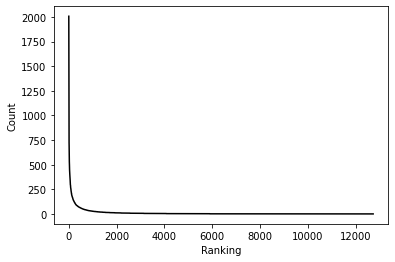

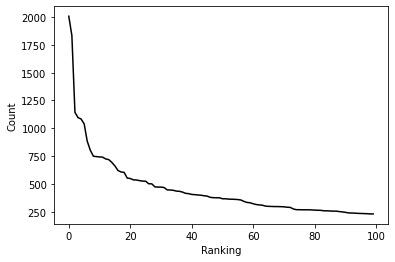

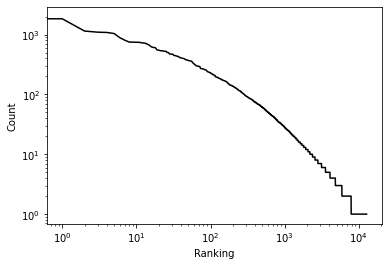

In [24]:
count_stats(ipcr)

27852 | 0.17598776704304914 | C08G
21736 | 0.13734274394828797 | C08L
14637 | 0.09248646223643223 | C09D
12270 | 0.07753015588173966 | C08K
9337 | 0.05899747884823172 | C08F
6171 | 0.03899255028086515 | C09J
5903 | 0.03729914508312218 | C07C
5417 | 0.03422826849318531 | C08J
4204 | 0.02656371437056508 | B32B
2976 | 0.018804380106280133 | C07D
2933 | 0.01853267703350794 | A61K
2326 | 0.014697240634142334 | G03F
2140 | 0.013521966877499826 | C09K
2058 | 0.013003835436399366 | B29C
2044 | 0.012915373970845629 | H01L
1921 | 0.012138176809194937 | G02B
1595 | 0.010078288397015057 | B41M
1432 | 0.009048344190925118 | B01J
1387 | 0.008764003765930962 | B05D
1212 | 0.007658235446509247 | H05K
1128 | 0.007127466653186824 | H01B
1092 | 0.0068999943131915 | C10M
1089 | 0.006881038284858557 | D06M
1022 | 0.006457686985422814 | C09B
911 | 0.005756313937103898 | B01D

Number of unique codes: 423


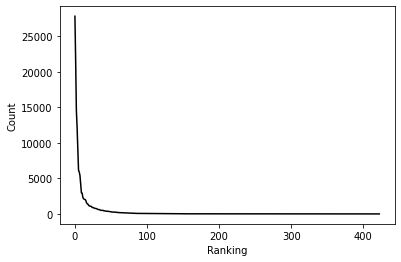

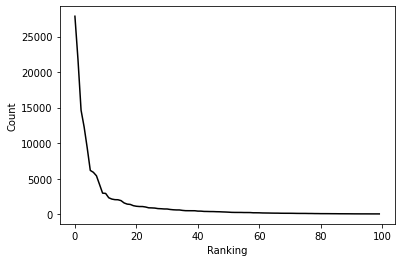

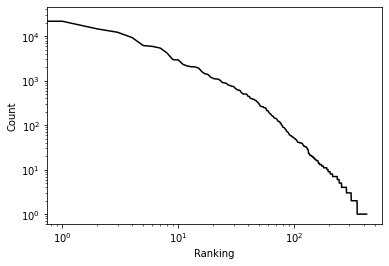

In [18]:
# Consider coarser codes (e.g. "C08L" in "C08L 69/ 00 A I")
ipcr_coarse = [s.split()[0] for s in ipcr]
count_stats(ipcr_coarse)